# waLBerla Tutorial 03: LBM Extensions


We start with the LBM simulation of an airfoil from last tutorial. In this tutorial we show how the boundary conditions can be set in a flexible way, by generating the airfoil geometry from an analytic description. Additionally we add some evaluation of force acting on the airfoil.

## A) Programmatic Boundary setup

In [1]:
from waLBerla import *
import waLBerla.plot as wplt
from waLBerla.geometry_setup import *
import numpy as np
from material.matplotlib_setup import *
import itertools
from IPython import display

Instead of loading the airfoil from an image file, we use the [NACA analytical description](https://en.wikipedia.org/wiki/NACA_airfoil) to generate the geometry.  The following function is just an implementation of the NACA airfoil description from Wikipedia. Additionally the airfoil can be rotated afterwards. The resulting array has value 1 in cells overlapped by the airfoil and zero otherwise.

In [2]:
def makeNacaAirfoil( length, thickness=30, angle=0 ):
    import scipy
    import scipy.ndimage    
    def nacaAirfoil(x, thickness,chordLength):
        xOverC = x / chordLength
        y_t = 0
        coeffs = [ 0.2969, -0.1260, - 0.3516, 0.2843, -0.1015 ]
        for coeff, exponent in zip( coeffs, [ 0.5, 1,2,3,4 ] ):
            y_t += coeff * xOverC ** exponent
        y_t *= 5 * thickness/100 * chordLength
        return y_t

    domain = np.zeros( (length, int(length*thickness/100) ) )
    it = np.nditer( domain, flags=['multi_index'], op_flags= ['readwrite'] )
    while not it.finished:
        x,y = it.multi_index
        y -= domain.shape[1]/2
        if abs(y) < nacaAirfoil( x, thickness, domain.shape[0] ):
            it[0] = 1
        it.iternext()
    domain = np.rot90( domain,1 )
    domain = scipy.ndimage.interpolation.rotate( domain, angle=-angle)

    domain[ domain > 0.5 ] = 1
    domain[ domain <= 0.5 ] = 0
    domain = domain.astype( np.int32 )
    return domain

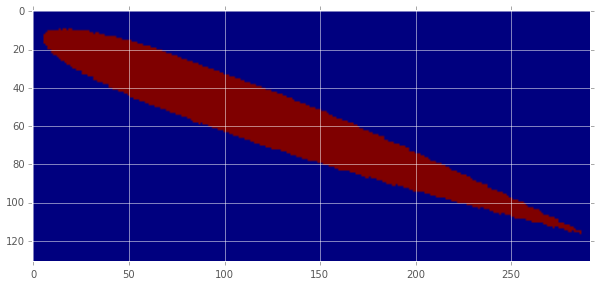

In [3]:
from ipywidgets import interactive
def showAirfoil( thickness=10, angle=20 ):
    wplt.style.use('ggplot')
    wplt.imshow( makeNacaAirfoil( 300, thickness, angle ) )
widgets = interactive(showAirfoil, thickness=(5,50,1), angle=(-45,45, 1) )
display.display( widgets )

In [4]:
airfoilArr = makeNacaAirfoil( length=200, **widgets.kwargs )

In [5]:
def setBoundariesChannel( blocks, boundaryHandlingID ):
    for block in blocks:
        b = block[ boundaryHandlingID ]
        if block.atDomainMinBorder[1]:
            b.forceBoundary( 'NoSlip',   makeSlice[ :, 0, :, 'g'] )
        if block.atDomainMaxBorder[1]:
            b.forceBoundary( 'NoSlip',   makeSlice[ :,-1, :, 'g'] )
        b.fillWithDomain()


# Lattice Model Setup
omega = 1.7
domainSize = ( airfoilArr.shape[1]*2, airfoilArr.shape[0] * 2 )
blocks = createUniformBlockGrid( cells=(500,200,1), periodic=(1,0,1) )
collisionModel =lbm.collisionModels.SRT( omega )
forceModel = lbm.forceModels.SimpleConstant( (1e-5,0,0) )
latticeModel = lbm.makeLatticeModel( "D2Q9", collisionModel, forceModel )
lbm.addPdfFieldToStorage( blocks, "pdfs", latticeModel, velocityAdaptor="vel", densityAdaptor="rho", initialDensity=1.0 )
field.addFlagFieldToStorage( blocks, 'flags' )
lbm.addBoundaryHandlingToStorage( blocks, 'boundary', 'pdfs', 'flags' )

# Boundary Setup
setBoundaryFromArray( blocks, 'boundary', makeSlice[0.3:0.7, 0.3:0.7 ,0.5], airfoilArr, { 1: 'NoSlip' }, resizeFunc=binaryResize )
setBoundariesChannel( blocks, 'boundary' )

sweep = lbm.makeCellwiseSweep( blocks, "pdfs", flagFieldID='flags', flagList=['fluid'] )

##########
from getCollide import getCollide
sweep.collide = getCollide(omega)
##########

# Communication
communication = createUniformBufferedScheme( blocks, 'D3Q19')
communication.addDataToCommunicate( field.createPackInfo( blocks, 'pdfs') )

def run( timesteps ):
    for t in range(timesteps):
        communication()
        for block in blocks: block['boundary']()
        for block in blocks: sweep.stream( block ); sweep.collide( block )

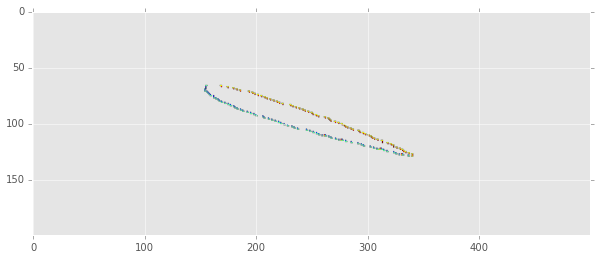

In [6]:
for i in range(1):
    run( 1 )
    setFieldUsingFlagMask(blocks, 'pdfs', np.NaN, 'flags', ['NoSlip'] )
    wplt.scalarField( blocks, 'rho', makeSlice[:,:,0.5] )
    display.display( wplt.gcf() )
    display.clear_output(wait=True)

## B) Evaluation

In [ ]:
class ForceCalculationMasks:
    @staticmethod
    def addToBlock( block, blockStorage ):
        pdfFieldArr  = field.toArray( block['pdfs'] )
        flagFieldArr = field.toArray( block['flags'] )[:,:,:,0]
        directions   = block['pdfs'].latticeModel.directions
        maskArr = np.zeros( pdfFieldArr.shape, dtype=bool )
        pdfDirectionArr = np.zeros( list(pdfFieldArr.shape) + [3] )

        fluidFlag  =  block['flags'].flag("fluid")
        noSlipFlag =  block['flags'].flag("NoSlip")

        innerPartOfDomain = itertools.product( range( 2, maskArr.shape[0]-2),
                                               range( 2, maskArr.shape[1]-2),
                                               range( maskArr.shape[2] ) )

        for x,y,z in innerPartOfDomain:
            if flagFieldArr[x,y,z] & fluidFlag:
                for dirIdx, dir in enumerate(directions):
                    nx, ny, nz = x+dir[0], y+dir[1], z+dir[2]
                    if flagFieldArr[nx,ny,nz] & noSlipFlag:
                        maskArr[x,y,z,dirIdx ] = True
                        pdfDirectionArr[x,y,z,:] = dir
        return ForceCalculationMasks( maskArr, pdfDirectionArr )

    def __init__(self, maskArr, pdfDirectionArr):
        self._maskArr = maskArr
        self._pdfDirectionArr = pdfDirectionArr

    def calculateForceOnBoundary(self, pdfField):
        force = np.array( [ 0.0 ] * 3 )
        pdfFieldArr     = field.toArray( pdfField )
        for i in range(3):
            fArr = pdfFieldArr[ self._maskArr ] * self._pdfDirectionArr[self._maskArr,i]
            force[i] += np.sum( fArr )
        return force

def calculateForceOnBoundary( blocks ):
    force = np.array( [ 0.0 ] * 3 )
    for block in blocks:
        force += block['ForceCalculation'].calculateForceOnBoundary( block['pdfs'] )
    return np.array( mpi.reduceReal( force, mpi.SUM ) )

blocks.addBlockData( 'ForceCalculation', ForceCalculationMasks.addToBlock )

6

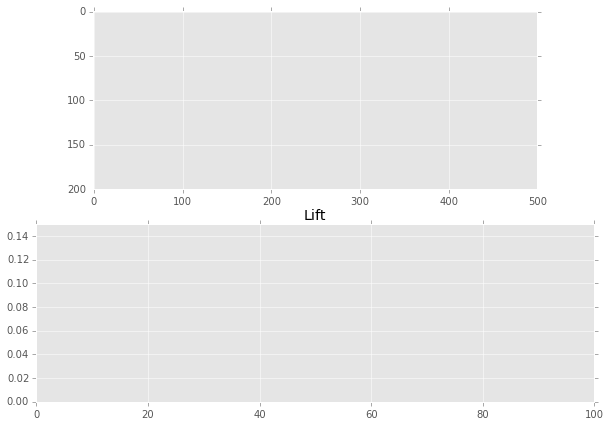

In [ ]:
lifts = []

for i in range(100):
    run( 10 )    
    plt.subplot(2,1,1)
    wplt.scalarField( blocks, 'rho', makeSlice[:,:,0.5] )
    plt.subplot(2,1,2)
    f = calculateForceOnBoundary( blocks )
    lifts.append( f[1] )
    wplt.plot( lifts, color='b' )
    wplt.ylim([0,0.15])
    wplt.xlim(0 , 100 )
    wplt.title("Lift")
    display.display( wplt.gcf() )
    display.clear_output(wait=True) 